# 데이터
소스: https://github.com/ECSIM/pem-dataset1/tree/master/Standard%20Test%20of%20Nafion%20Membrane%20112
### 구조
- Anode: 
	- Carbon paper Ballard
	- Platinum-Carbon 20% 
	- Nafion solution (27% weight)
	- 80ml Isopropyl alcohol
	- 20ml double distilled water 
	- Loading of Platinum= 0.39 mg/cm2
- Cathode: 
	- Carbon paper Ballard
	- Platinum-Carbon 20%
	- Nafion solution (25% weight)
	- 80ml Isopropyl alcohol
	- 20ml double distilled water
	- Loading of Platinum= 0.39 mg/cm2

### 실험 환경
- Cell temperature= 75 C
- Anode temperature= 80 C
- Cathode temperature= 48-59-70-75 C

# 데이터 다운로드

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/GuGroup/ShortNNTutorial/main/NNExample/data.csv", "data.csv")

('data.csv', <http.client.HTTPMessage at 0x21198adaaf0>)

# 데이터 분석
데이터 분석
<img src="https://github.com/GuGroup/ShortNNTutorial/blob/main/NNExample/img/data.png?raw=1" style="max-width: 800px;">

A열 - 전류 밀도 - 예측 하고 싶은 값

B열 - 셀 전압   - input 1

C열 - 수소 압력 - input 2

D열 - 상대 습도 - input 3

E열 - 막 압축   - input 4

<img src="https://github.com/GuGroup/ShortNNTutorial/blob/main/NNExample/img/plots.png?raw=1" style="max-width: 800px;">

# 파이썬상에서 데이터 불러오기

In [6]:
import csv
import torch

with open('data.csv') as f:
    reader = csv.reader(f)
    next(reader)
    data = []
    for row in reader:
        datum = []
        for column in row:
            datum.append(float(column))
        data.append(datum)

data = torch.Tensor(data)

y = data[:,:1]
x = data[:,1:]


# 데이터 섞기

In [7]:
randomized_idx = torch.randperm(data.shape[0])

train_ratio = 0.8
ntrain = int(data.shape[0]*train_ratio)

idx_train = randomized_idx[:ntrain]
idx_test = randomized_idx[ntrain:]

x_train = x[idx_train,:]
y_train = y[idx_train]

x_test  = x[idx_test,:]
y_test  = y[idx_test]

# 데이터 Normalization

In [8]:
x_train_mean = x_train.mean(0)
x_train_std = x_train.std(0)

x_train_normalized = (x_train -x_train_mean)/x_train_std
x_test_normalized = (x_test -x_train_mean)/x_train_std

y_train_mean  = y_train.mean()
y_train_std  = y_train.std()
y_train_normalized = (y_train - y_train_mean)/y_train_std
y_test_normalized = (y_test - y_train_mean)/y_train_std


# 모델 구축

In [9]:
class NeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(4, 32),
                        torch.nn.Softplus(),
                        torch.nn.Linear(32, 32),
                        torch.nn.Softplus(),
                        torch.nn.Linear(32, 1))
        
    def forward(self, x):
        y = self.model(x)
        return y

model = NeuralNetwork()

# 모델 학습

In [10]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),0.001)
for i in range(10000):
    y_train_normalized_pred = model(x_train_normalized)
    loss = criterion(y_train_normalized_pred,y_train_normalized)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (i+1) % 1000 == 0:
        print(i+1,'%.5f'%loss)

999 0.02299
1999 0.01441
2999 0.00453
3999 0.00331
4999 0.00277
5999 0.00235
6999 0.00201
7999 0.00163
8999 0.00133
9999 0.00108


# 모델 테스트 

In [11]:
y_test_normalized_pred = model(x_test_normalized)
loss = criterion(y_test_normalized_pred,y_test_normalized)
print(loss)

y_test_pred = y_test_normalized_pred*y_train_std+y_train_mean
print(' Pred  Real')
for i in range(y_test_pred.shape[0]):
    print('%5.0f'%y_test_pred[i],'%5.0f'%y_test[i])


tensor(0.0017, grad_fn=<MseLossBackward0>)
 Pred  Real
   20    44
  938   955
  983   979
  771   733
   18    65
  306   291
  800   804
 1424  1440
 1372  1390
  889   910
 1740  1700
   55    36
 1853  1870
   12    36
  863   865
  464   465
  119   120
   54    37
  631   627
    2    20
  227   245
  539   547
   63    90
   58    74
  472   483
 2097  2120
  661   638
  356   362
 1664  1660
  330   307
  532   538
   19    25
  638   627
  876   876
 1020  1040
 1022  1000
  285   281
  793   812
 1802  1820
   76    63
  827   832
  589   586
  528   584
   59    74
 1499  1490
 1232  1230
 1949  1970
   14     1
  290   237
 1546  1560
 1162  1150
 1532  1520
 1563  1550
  122   119
  560   557
 1254  1270
   20    28
 1055  1050
   48    83
   62    40
  532   509
 1263  1320
 1131  1140
   91    92
  249   227
 1335  1410
 1331  1290
  982  1060
 1263  1250
   42    33
 2032  2030
  923   951
 1411  1420
 1096  1130
   71    59
  409   361
  379   369
  810   812
   16    

# 예측 그림 그리기

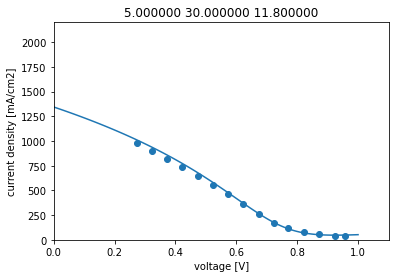

In [15]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import matplotlib.pyplot as plt

pressure = 5
relative_humidity =30
membrane_compression = 11.8

example_data = []
for d in data:
    if d[2] == pressure and d[3] == relative_humidity and d[4] ==membrane_compression:
        example_data.append(d)
example_data = torch.stack(example_data)

test_x_data = []
voltages = torch.linspace(0.0,1.0,100)
for v in voltages:
    test_x_data.append([v,pressure,relative_humidity,membrane_compression])
test_x_data = (torch.tensor(test_x_data) -x_train_mean)/x_train_std

test_y_data = model(test_x_data)
test_y_data = test_y_data.detach()
test_y_data = test_y_data*y_train_std+y_train_mean

plt.figure()
plt.scatter(example_data[:,1],example_data[:,0])
plt.ylabel('current density [mA/cm2]')
plt.xlabel('voltage [V]')
plt.ylim([0,2200])
plt.xlim([0,1.1])
plt.title('%f %f %f'%(pressure,relative_humidity,membrane_compression))
plt.plot(voltages,test_y_data)